In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import skimage
from skimage import measure
import random

In [ ]:
img = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16//nifti/Image_LIDC_IDRI_0001.nii.gz")
label = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16//nifti/Label_LIDC_IDRI_0001.nii.gz")
mask = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16//nifti/Lung_mask_LIDC_IDRI_0001.nii.gz")

In [205]:
'''
print(img.get_data_dtype())
test_numpy_image = np.asanyarray(img.dataobj, dtype=np.int16)
print(test_numpy_image.dtype)
print(test_numpy_image.shape)
#img.shape
'''

affine = img.affine
print(affine)

[[  -0.703125      0.            0.          166.        ]
 [  -0.            0.703125      0.         -187.59687805]
 [   0.           -0.            2.5        -340.        ]
 [   0.            0.            0.            1.        ]]


In [168]:
#turning images into numpy array and keeping the images as an int16

np_img = np.asanyarray(img.dataobj, dtype=np.int16)
np_mask = np.asanyarray(mask.dataobj, dtype=np.int16)
np_label = np.asanyarray(label.dataobj, dtype=np.int16)

print(np_img.shape)
print(np_mask.shape)
print(np_label.shape)

print(np_img.dtype)
print(np_mask.dtype)
print(np_label.dtype)

(360, 360, 332)
(360, 360, 332)
(360, 360, 332)
int16
int16
int16


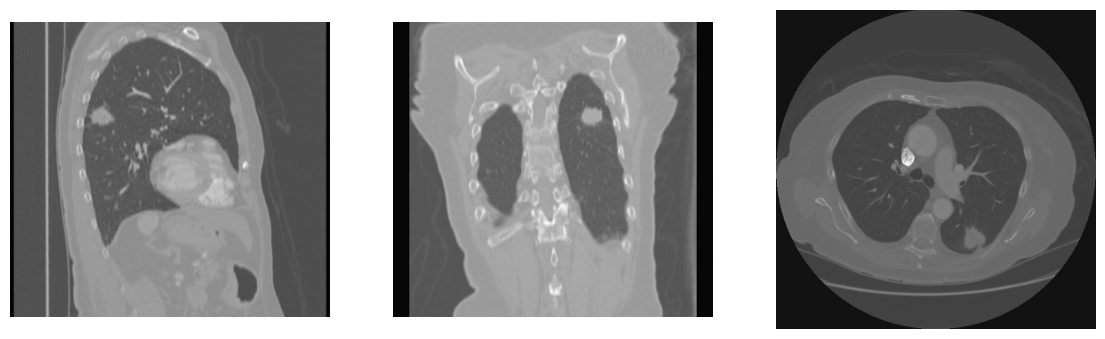

In [206]:
slicez = np_img[220, :, :]
slicey = np_img[:, 100, :]
slicex = np_img[:, :, 225]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [207]:
unique_vals = np.unique(np_img)
print(unique_vals)

[-2465 -2463 -2461 ...  3748  3772  3787]


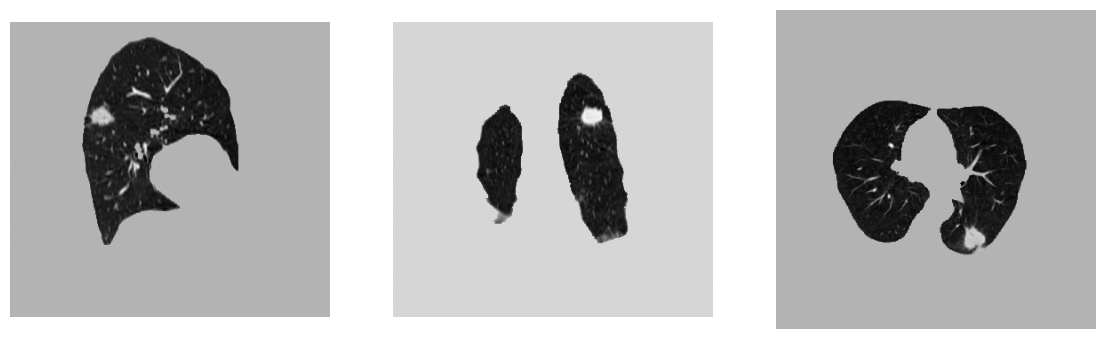

In [208]:
binary = np_mask > 0

masked_img = binary * np_img

slicez = masked_img[220, :, :]
slicey = masked_img[:, 100, :]
slicex = masked_img[:, :, 225]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [209]:
print(masked_img.shape)

print(masked_img.max())
print(masked_img.min())

print(np_img.max())
print(np_img.min())

print(np.percentile(masked_img, [1, 99]))

(360, 360, 332)
697
-1318
3787
-2465
[-922.    0.]


In [210]:
labels = measure.label(np_label, connectivity=1)
props = measure.regionprops(labels)

for prop in props:
    print("Label:", prop.label)
    print("Volume:", prop.area)            # number of voxels
    print("Centroid:", prop.centroid)      # (z, row, col)
    print("Bounding box:", prop.bbox)      # (min_z, min_row, min_col, max_z, max_row, max_col)


Label: 1
Volume: 6781.0
Centroid: (np.float64(222.26294056923757), np.float64(101.13036425306002), np.float64(224.57277687656688))
Bounding box: (210, 87, 215, 236, 118, 235)
Label: 2
Volume: 3.0
Centroid: (np.float64(218.0), np.float64(118.0), np.float64(223.0))
Bounding box: (218, 118, 222, 219, 119, 225)


In [211]:
print(props[0].centroid[0])

patch3d = masked_img[props[0].bbox[0]:props[0].bbox[3], props[0].bbox[1]:props[0].bbox[4], props[0].bbox[2]:props[0].bbox[5]]

222.26294056923757


(31, 20)
(26, 20)
(26, 31)


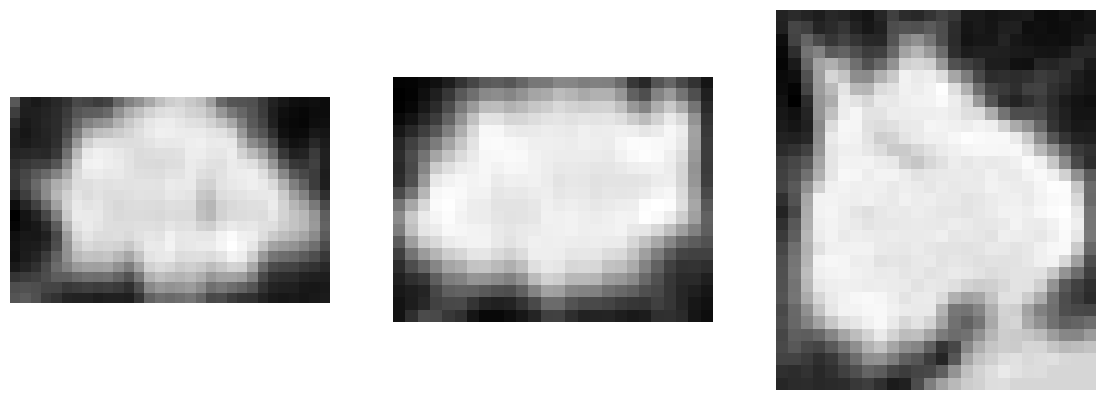

In [212]:
slicez = patch3d[10, :, :]
slicey = patch3d[:, 10, :]
slicex = patch3d[:, :, 10]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    print(s.shape)
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [ ]:
#variables

half_patch_size = 32

#going over each axial slice
for slice_num in range(masked_img.shape[2]):

    img_slice = masked_img[:, :, slice_num]
    label_slice = np_label[:, :, slice_num]

    #getting the labels
    labels = measure.label(label_slice, connectivity=1)

    #getting regionprops if there is lesion in slice
    if labels.max() != 0:

        props = measure.regionprops(labels)

        #going over the regions
        for prop in props:

            #check is the region is larger than 3 pixels
            if prop.area > 3:

                #check if the region plus the added number are within image bounds
                if prop.centroid[0] - 47 > 0 and prop.centroid[0] + 47 < img_slice.shape[0] and prop.centroid[1] - 47 > 0 and prop.centroid[1] + 47 < img_slice.shape[0]:
                    
                    #create 5 patches per slice
                    for reps in range(5):

                        #get a random deviation from the centroid
                        y_drift = random.randint(-15, 15)
                        x_drift = random.randint(-15, 15)

                        #crop the image to a patch of size 64 with the centroid in the middle and a random drift
                        img_patch2d = img_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        label_patch2d = label_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        
                        #random flipping of the images for a more diverse dataset
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.fliplr(img_patch2d)
                            label_patch2d = np.fliplr(label_patch2d)
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.flipud(img_patch2d)
                            label_patch2d = np.flipud(label_patch2d)

                        #save the images as .npy
                        img_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/image_1_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        label_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/labels/image_1_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        np.save(img_path, img_patch2d)
                        np.save(label_path, label_patch2d)
                        
                        '''#visualizing patches code
                        plt.figure()
                        plt.imshow(np.flipud(img_patch2d.T), cmap='gray')
                        plt.axis("off")
                        plt.figure()
                        plt.imshow(np.flipud(label_patch2d.T), cmap='gray')
                        plt.axis("off")'''
                        #break


'''#to change slice change the range, the slice axis and the name of the file

#going over each coronal slice
for slice_num in range(masked_img.shape[1]):

    img_slice = masked_img[:, slice_num, :]
    label_slice = np_label[:, slice_num, :]

    #getting the labels
    labels = measure.label(label_slice, connectivity=1)

    #getting regionprops if there is lesion in slice
    if labels.max() != 0:

        props = measure.regionprops(labels)

        #going over the regions
        for prop in props:

            #check is the region is larger than 3 pixels
            if prop.area > 3:

                #check if the region plus the added number are within image bounds
                if prop.centroid[0] - 47 > 0 and prop.centroid[0] + 47 < img_slice.shape[0] and prop.centroid[1] - 47 > 0 and prop.centroid[1] + 47 < img_slice.shape[0]:
                    
                    #create 5 patches per slice
                    for reps in range(5):

                        #get a random deviation from the centroid
                        y_drift = random.randint(-15, 15)
                        x_drift = random.randint(-15, 15)

                        #crop the image to a patch of size 64 with the centroid in the middle and a random drift
                        img_patch2d = img_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        label_patch2d = label_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        
                        #random flipping of the images for a more diverse dataset
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.fliplr(img_patch2d)
                            label_patch2d = np.fliplr(label_patch2d)
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.flipud(img_patch2d)
                            label_patch2d = np.flipud(label_patch2d)

                        #save the images as .npy
                        img_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/image_2_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        label_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/labels/image_2_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        np.save(img_path, img_patch2d)
                        np.save(label_path, label_patch2d)
                        
                        #visualizing patches code
                        plt.figure()
                        plt.imshow(np.flipud(img_patch2d.T), cmap='gray')
                        plt.axis("off")
                        plt.figure()
                        plt.imshow(np.flipud(label_patch2d.T), cmap='gray')
                        plt.axis("off")
                        break '''              

'#to change slice change the range, the slice axis and the name of the file\n\n#going over each coronal slice\nfor slice_num in range(masked_img.shape[1]):\n\n    img_slice = masked_img[:, slice_num, :]\n    label_slice = np_label[:, slice_num, :]\n\n    #getting the labels\n    labels = measure.label(label_slice, connectivity=1)\n\n    #getting regionprops if there is lesion in slice\n    if labels.max() != 0:\n\n        props = measure.regionprops(labels)\n\n        #going over the regions\n        for prop in props:\n\n            #check is the region is larger than 3 pixels\n            if prop.area > 3:\n\n                #check if the region plus the added number are within image bounds\n                if prop.centroid[0] - 47 > 0 and prop.centroid[0] + 47 < img_slice.shape[0] and prop.centroid[1] - 47 > 0 and prop.centroid[1] + 47 < img_slice.shape[0]:\n\n                    #create 5 patches per slice\n                    for reps in range(5):\n\n                        #get a